<a href="https://colab.research.google.com/github/mkirby1995/DS-Unit-2-Sprint-3-Classification-Validation/blob/master/Iris_Classification_and_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import

In [1]:
!pip install category_encoders

     |████████████████████████████████| 92kB 5.2MB/s 


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import graphviz
import category_encoders as ce
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [0]:
Iris = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(Iris, header=None, names=['sepal_length',
                                           'sepal_width',
                                           'petal_length',
                                           'petal_width',
                                           'species'])

Since this is a very small and clean dataset we will add some variation

In [4]:
for i in range(1000):
  df = df.append(df.sample())
  
df.index = range(1150)
df.index.nunique()

1150



---



##Explore

In [5]:
df.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 5 columns):
sepal_length    1150 non-null float64
sepal_width     1150 non-null float64
petal_length    1150 non-null float64
petal_width     1150 non-null float64
species         1150 non-null object
dtypes: float64(4), object(1)
memory usage: 45.0+ KB


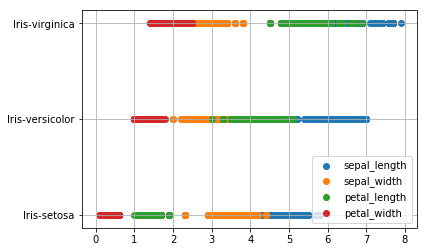

In [7]:
for col in df.drop(columns='species').columns:
  plt.scatter(df[col], df['species'], label=col)
  
plt.grid()  
plt.legend()
plt.show();



---



##Model

###Train, Validation, Test Split

Encode Species

In [0]:
df['species'] = df['species'].replace({'Iris-versicolor':1, 'Iris-setosa':2, 'Iris-virginica':3})

Train, Validation, Test Split Function

In [0]:
def three_way_split(DataFrame, Target):
  """
  Given a DataFrame name and a feature(str) this function will preform a
  three way split and return the shapes of each set.
  """
  
  # Define sets as global variables
  global xtrain, xval, xtest, ytrain, yval, ytest, x, y
  
  # X and Y assignment
  x = DataFrame.drop(columns=Target)
  y = DataFrame[Target]
  
  # First split
  xtrain, xtest, ytrain, ytest = train_test_split(
      x,
      y,
      test_size=.2,
      random_state=42,
      stratify=y)
  
  # Second split
  xtrain, xval, ytrain, yval = train_test_split(
      xtrain,
      ytrain,
      test_size=.3,
      random_state=42,
      stratify=ytrain)
  
  # Return shapes
  print(' X Train', xtrain.shape, '\n',
        'X Validation', xval.shape, '\n',
        'X Test', xtest.shape, '\n',
        'Y Train', ytrain.shape, '\n',
        'Y Validation', yval.shape, '\n',
        'Y Test', ytest.shape)

Run Split

In [10]:
three_way_split(df, 'species')

 X Train (644, 4) 
 X Validation (276, 4) 
 X Test (230, 4) 
 Y Train (644,) 
 Y Validation (276,) 
 Y Test (230,)




---



###Majority Baseline

Check the normalized counts for each species

In [11]:
ytrain.value_counts(normalize=True)

3    0.343168
1    0.332298
2    0.324534
Name: species, dtype: float64

Run a majority baseline model

In [12]:
majority_class = yval.mode()[0]
majority_class_pred = [majority_class] * len(yval)
accuracy_score(yval, majority_class_pred)

0.34057971014492755



---



###Decision Stump

In [13]:
stump = DecisionTreeClassifier(max_depth=3)
stump.fit(xtrain, ytrain)
stump.score(xtrain, ytrain)

0.9875776397515528

In [0]:
stump_pred_ = []
for _ in range(len(stump.predict_proba(xval)[:,0])):
  stump_pred_.append(
      max(
          [stump.predict_proba(xval)[:,0][_],
           stump.predict_proba(xval)[:,1][_],
           stump.predict_proba(xval)[:,2][_]]))

In [0]:
stump_pred_proba = stump_pred_

In [0]:
stump_pred = stump.predict(xval)

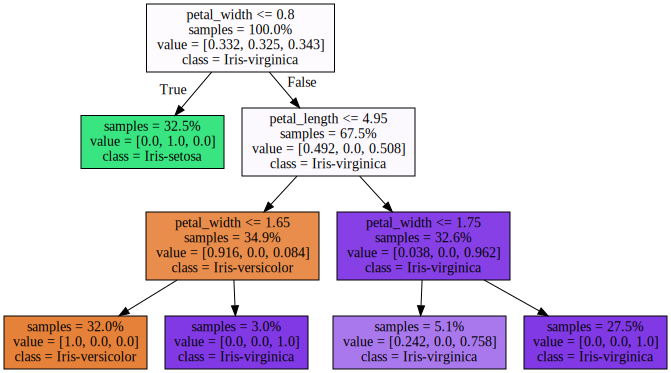

In [17]:
dot_data = export_graphviz(stump, out_file=None, feature_names=xtrain.columns, 
                           class_names=['Iris-versicolor', 'Iris-setosa', 'Iris-virginica'], filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)



---



###Logistic Regression

In [0]:
pipeline = make_pipeline(
  ce.OneHotEncoder(use_cat_names=True),
  StandardScaler(),
  LogisticRegression(solver='lbfgs', max_iter=1000))

In [19]:
scores = cross_val_score(pipeline, xtrain, ytrain, scoring='accuracy', cv=10, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished


In [20]:
print('Cross-Validation accuracy scores:', scores,'\n\n')
print('Average:', scores.mean())

Cross-Validation accuracy scores: [0.95454545 1.         0.93846154 0.96923077 1.         1.
 0.96875    0.921875   0.890625   0.95238095] 


Average: 0.9595868714618714


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


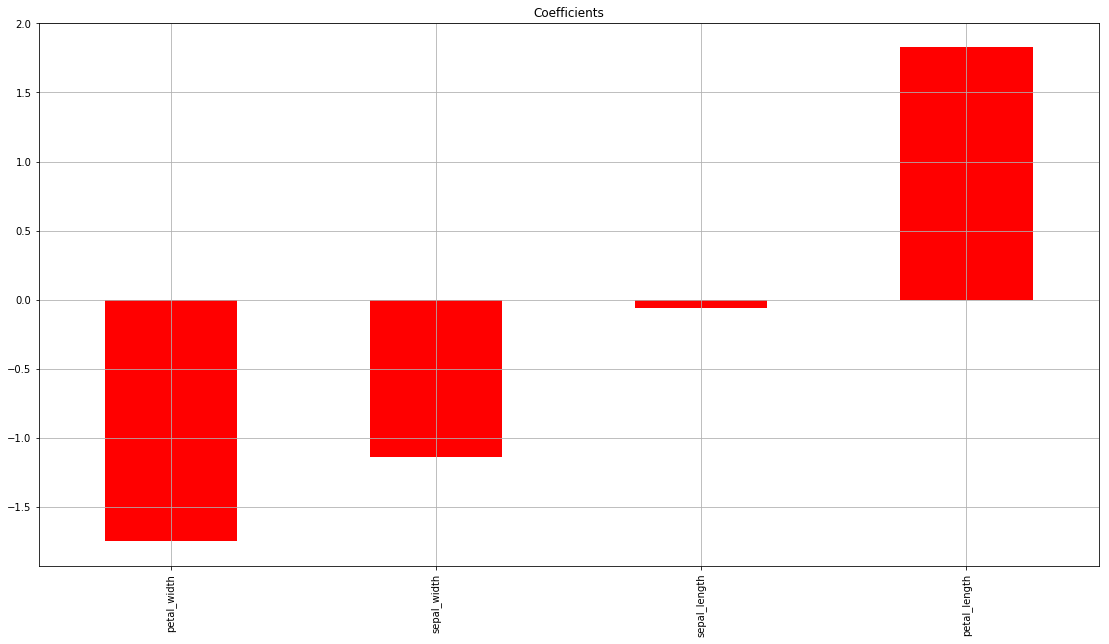

In [21]:
# (Re)fit on training data
pipeline.fit(xtrain, ytrain)

# Visualize coefficients
plt.figure(figsize=(19,10))
plt.title('Coefficients')

coefficients = pipeline.named_steps['logisticregression'].coef_[0]

feature_names = pipeline.named_steps['onehotencoder'].transform(xtrain).columns

pd.Series(coefficients, feature_names).sort_values().plot.bar(color='red')
plt.grid()
plt.show();

In [0]:
logistic_pred = pipeline.predict(xval)

In [0]:
log_pred = []
for _ in range(len(pipeline.predict_proba(xval)[:,0])):
  log_pred.append(
      max(
          [pipeline.predict_proba(xval)[:,0][_],
           pipeline.predict_proba(xval)[:,1][_],
           pipeline.predict_proba(xval)[:,2][_]]))

In [0]:
logistic_pred_proba = log_pred



---



###Random Forrest

In [25]:
random_forest = RandomForestClassifier(max_depth=2, n_estimators=25)
random_forest.fit(xtrain, ytrain)
random_forest.score(xval,yval)

0.9528985507246377

In [0]:
random_forest_pred = random_forest.predict(xval)

In [0]:
forest = []
for _ in range(len(random_forest.predict_proba(xval)[:,0])):
  forest.append(
      max(
          [random_forest.predict_proba(xval)[:,0][_],
           random_forest.predict_proba(xval)[:,1][_],
           random_forest.predict_proba(xval)[:,2][_]]))

In [0]:
random_forest_pred_proba = forest



---



###Graident Boosting

In [29]:
grad_boost = XGBClassifier(max_depth=2, n_estimators=25)
grad_boost.fit(xtrain, ytrain)
grad_boost.score(xval,yval)

0.9927536231884058

In [0]:
grad_boost_pred = grad_boost.predict(xval)

In [0]:
boost = []
for _ in range(len(grad_boost.predict_proba(xval)[:,0])):
  boost.append(
      max(
          [grad_boost.predict_proba(xval)[:,0][_],
           grad_boost.predict_proba(xval)[:,1][_],
           grad_boost.predict_proba(xval)[:,2][_]]))

In [0]:
grad_boost_pred_proba = boost



---



##Model Validation and Comparision

In [33]:
compare = pd.DataFrame(yval)


compare['majority_class_pred'] = (compare['species']*0) + yval.mode()[0]
compare['majority_class_pred_proba'] = (compare['species']*0)+1

compare['stump_pred'] = stump_pred
compare['stump_pred_proba'] = stump_pred_proba

compare['logistic_pred'] = logistic_pred
compare['logistic_pred_proba'] = logistic_pred_proba

compare['random_forest_pred'] = random_forest_pred
compare['random_forest_pred_proba'] = random_forest_pred_proba

compare['grad_boost_pred'] = grad_boost_pred
compare['grad_boost_pred_proba'] = grad_boost_pred_proba

compare['Majority_Model_Correct'] = compare['species'] == compare['majority_class_pred']
compare['Stump_Model_Correct'] = compare['species'] == compare['stump_pred']
compare['Logistic_Model_Correct'] = compare['species'] == compare['logistic_pred']
compare['Random_Forest_Correct'] = compare['species'] == compare['random_forest_pred']
compare['Graident_Boost_Correct'] = compare['species'] == compare['grad_boost_pred']


compare.head()

,species,majority_class_pred,majority_class_pred_proba,stump_pred,stump_pred_proba,logistic_pred,logistic_pred_proba,random_forest_pred,random_forest_pred_proba,grad_boost_pred,grad_boost_pred_proba,Majority_Model_Correct,Stump_Model_Correct,Logistic_Model_Correct,Random_Forest_Correct,Graident_Boost_Correct
559,1,3,1,1,1.0,1,0.960145,1,0.891115,1,0.907527,False,True,True,True,True
640,3,3,1,3,1.0,3,0.596936,3,0.923175,3,0.928019,True,True,True,True,True
817,1,3,1,1,1.0,1,0.902621,1,0.816148,1,0.907527,False,True,True,True,True
915,1,3,1,1,1.0,1,0.571606,1,0.891115,1,0.907527,False,True,True,True,True
459,1,3,1,1,1.0,1,0.934369,1,0.891115,1,0.907527,False,True,True,True,True




---



###Model Prediction Value Counts

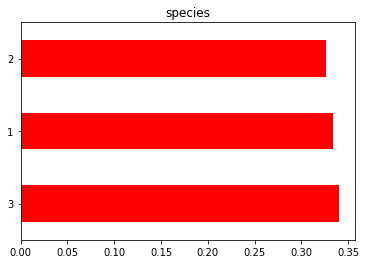

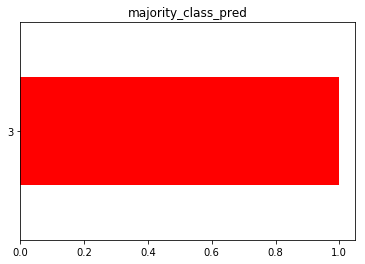

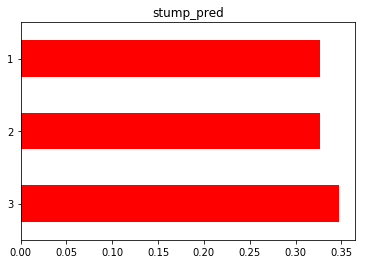

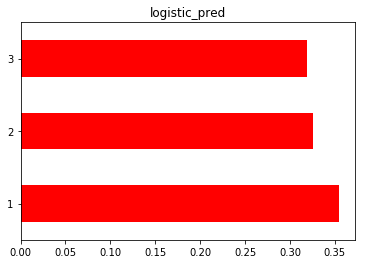

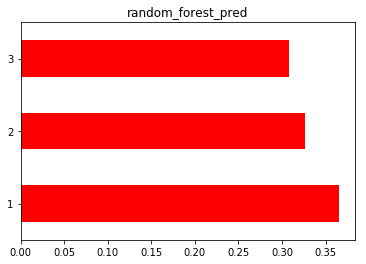

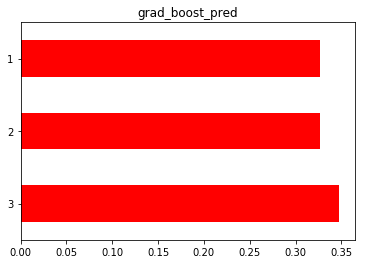

In [34]:
Predictions = ['species',
               'majority_class_pred',
               'stump_pred', 
               'logistic_pred',
               'random_forest_pred',
               'grad_boost_pred']

for _ in Predictions:
  compare[_].value_counts(normalize=True).plot.barh(color='red')
  plt.title(_)
  plt.show();




---



###Model Correctness Counts

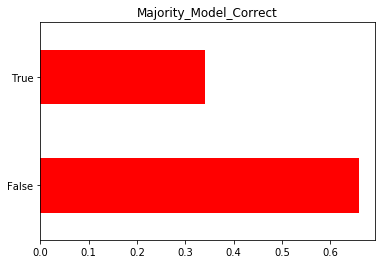

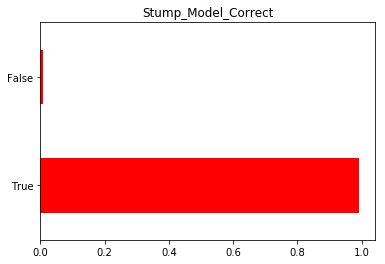

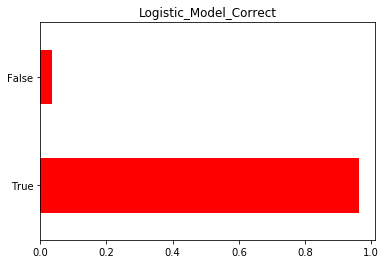

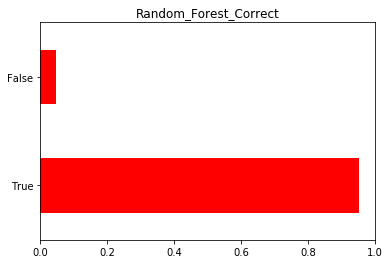

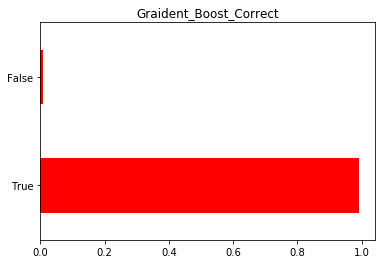

In [35]:
Correct = ['Majority_Model_Correct',
           'Stump_Model_Correct',
           'Logistic_Model_Correct',
           'Random_Forest_Correct',
           'Graident_Boost_Correct']

for _ in Correct:
  compare[_].value_counts(normalize=True).plot.barh(color='red')
  plt.title(_)
  plt.show();



---



###Model Prediction Probability Distributions

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


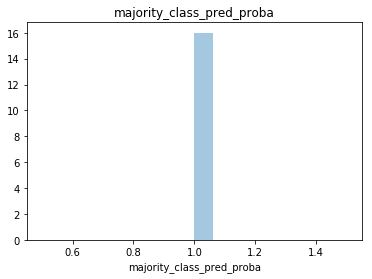

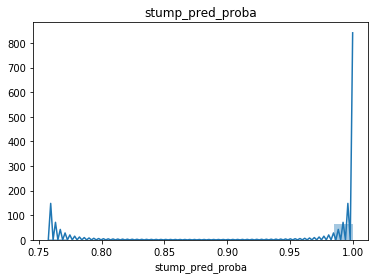

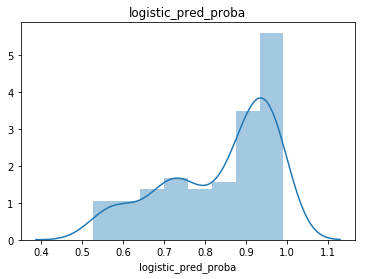

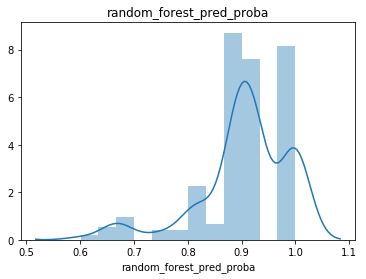

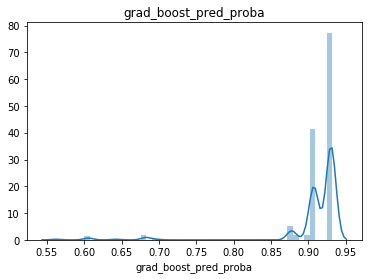

In [36]:
Probabilities = ['majority_class_pred_proba',
                 'stump_pred_proba',
                 'logistic_pred_proba',
                 'random_forest_pred_proba',
                 'grad_boost_pred_proba']

for _ in Probabilities:
  sns.distplot(compare[_])
  plt.title(_)
  plt.show();



---



###Model Confusion Matrices

                 precision    recall  f1-score   support

Iris-versicolor       1.00      1.00      1.00        92
    Iris-setosa       1.00      1.00      1.00        90
 Iris-virginica       1.00      1.00      1.00        94

      micro avg       1.00      1.00      1.00       276
      macro avg       1.00      1.00      1.00       276
   weighted avg       1.00      1.00      1.00       276



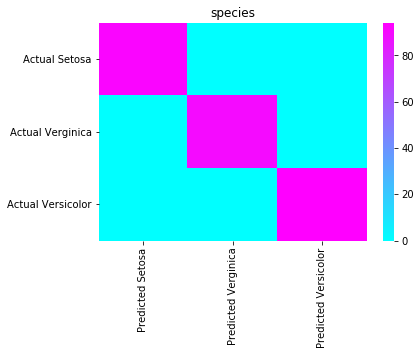

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

Iris-versicolor       0.00      0.00      0.00        92
    Iris-setosa       0.00      0.00      0.00        90
 Iris-virginica       0.34      1.00      0.51        94

      micro avg       0.34      0.34      0.34       276
      macro avg       0.11      0.33      0.17       276
   weighted avg       0.12      0.34      0.17       276



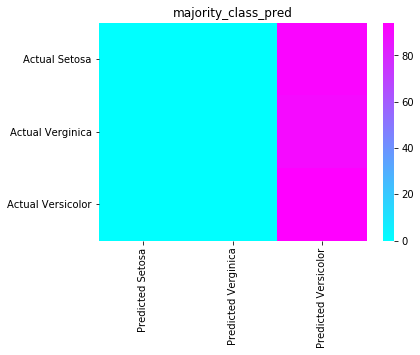

                 precision    recall  f1-score   support

Iris-versicolor       1.00      0.98      0.99        92
    Iris-setosa       1.00      1.00      1.00        90
 Iris-virginica       0.98      1.00      0.99        94

      micro avg       0.99      0.99      0.99       276
      macro avg       0.99      0.99      0.99       276
   weighted avg       0.99      0.99      0.99       276



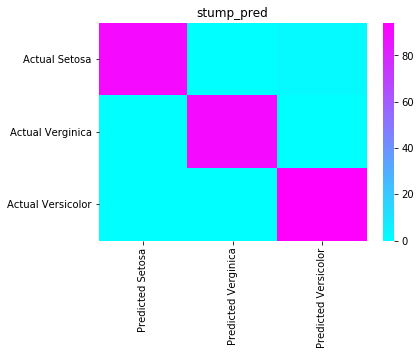

                 precision    recall  f1-score   support

Iris-versicolor       0.92      0.98      0.95        92
    Iris-setosa       1.00      1.00      1.00        90
 Iris-virginica       0.98      0.91      0.95        94

      micro avg       0.96      0.96      0.96       276
      macro avg       0.97      0.96      0.96       276
   weighted avg       0.97      0.96      0.96       276



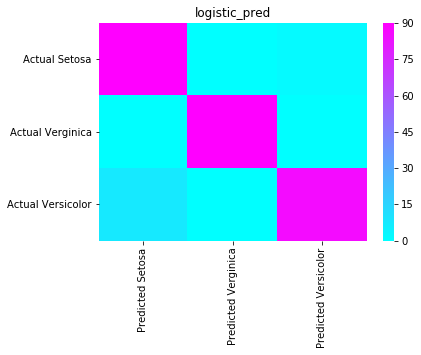

                 precision    recall  f1-score   support

Iris-versicolor       0.89      0.98      0.93        92
    Iris-setosa       1.00      1.00      1.00        90
 Iris-virginica       0.98      0.88      0.93        94

      micro avg       0.95      0.95      0.95       276
      macro avg       0.96      0.95      0.95       276
   weighted avg       0.96      0.95      0.95       276



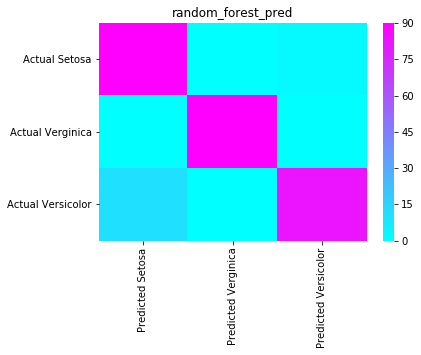

                 precision    recall  f1-score   support

Iris-versicolor       1.00      0.98      0.99        92
    Iris-setosa       1.00      1.00      1.00        90
 Iris-virginica       0.98      1.00      0.99        94

      micro avg       0.99      0.99      0.99       276
      macro avg       0.99      0.99      0.99       276
   weighted avg       0.99      0.99      0.99       276



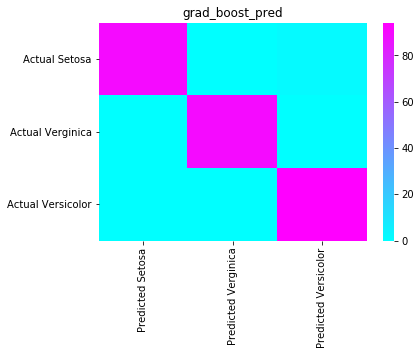

In [37]:
for _ in Predictions:
  print(classification_report(yval, compare[_], target_names=['Iris-versicolor', 'Iris-setosa', 'Iris-virginica']))
  con_matrix = pd.DataFrame(confusion_matrix(yval, compare[_]), 
             columns=['Predicted Setosa', 'Predicted Verginica', 'Predicted Versicolor'], 
             index=['Actual Setosa', 'Actual Verginica', 'Actual Versicolor'])
  sns.heatmap(data=con_matrix, cmap='cool');
  plt.title(_)
  plt.show();



---

